<a href="https://colab.research.google.com/github/youngsiiimba/pump-sensor-data/blob/main/TCN_model_predictive_maintenance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wget
!pip install keras-tcn
import wget
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from tqdm.notebook import tqdm

from tcn import TCN

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=a441eae14f9cbc55a554fc20430027db7b35bdbf4f2eb1198f8f1e1a7dffad9c
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.2 MB/s 


##Data Import

In [2]:
!git clone https://github.com/youngsiiimba/pump-sensor-data.git

Cloning into 'pump-sensor-data'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 9 (delta 1), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (9/9), done.


In [3]:
!unzip /content/pump-sensor-data/pump_sensor_data_zipped.zip 

Archive:  /content/pump-sensor-data/pump_sensor_data_zipped.zip
  inflating: sensor.csv              


In [4]:
df = pd.read_csv('/content/sensor.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 55 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      220320 non-null  int64  
 1   timestamp       220320 non-null  object 
 2   sensor_00       210112 non-null  float64
 3   sensor_01       219951 non-null  float64
 4   sensor_02       220301 non-null  float64
 5   sensor_03       220301 non-null  float64
 6   sensor_04       220301 non-null  float64
 7   sensor_05       220301 non-null  float64
 8   sensor_06       215522 non-null  float64
 9   sensor_07       214869 non-null  float64
 10  sensor_08       215213 non-null  float64
 11  sensor_09       215725 non-null  float64
 12  sensor_10       220301 non-null  float64
 13  sensor_11       220301 non-null  float64
 14  sensor_12       220301 non-null  float64
 15  sensor_13       220301 non-null  float64
 16  sensor_14       220299 non-null  float64
 17  sensor_15 

In [5]:
df.head(10)

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL
5,5,2018-04-01 00:05:00,2.453588,47.09201,53.1684,46.397568,637.6157,78.18568,13.41146,16.16753,...,42.70833,38.773150,63.65741,51.79398,38.773150,164.6412,66.55093,241.6088,201.6782,NORMAL
6,6,2018-04-01 00:06:00,2.455556,47.04861,53.1684,46.397568,633.3333,75.81614,13.43316,16.13136,...,43.22916,38.194440,61.92130,51.79398,39.062500,171.8750,67.70834,240.1620,200.2315,NORMAL
7,7,2018-04-01 00:07:00,2.449653,47.13541,53.1684,46.397568,630.6713,75.77331,13.25231,16.12413,...,42.96875,38.194443,59.60648,50.92593,39.351850,178.5301,68.57639,241.3194,201.0995,NORMAL
8,8,2018-04-01 00:08:00,2.463426,47.09201,53.1684,46.397568,631.9444,74.58916,13.28848,16.13136,...,42.18750,38.194440,57.87037,50.63657,39.351850,182.0023,69.44444,243.0556,201.6782,NORMAL
9,9,2018-04-01 00:09:00,2.445718,47.17882,53.1684,46.397568,641.7823,74.57428,13.38252,16.24711,...,41.66666,39.062500,56.42361,50.63657,39.062500,186.6319,69.73380,246.5278,200.8102,NORMAL


In [6]:
# The first column has no name. Give it a name!
df.rename(columns={ df.columns[0]: "Samplenr" }, inplace = True)

##Data preparation

In [7]:
#Remove sensor_15 and sensor_50, too many missing values
df = df.drop(['sensor_15','sensor_50','Samplenr'],axis=1)

In [8]:
100*df['machine_status'].value_counts()/len(df)

NORMAL        93.425926
RECOVERING     6.570897
BROKEN         0.003177
Name: machine_status, dtype: float64

In [9]:
columns = [col for col in df.columns if not col.find('sensor')]
for col in columns:
    df[col] = df[col].fillna(df[col].mean())

In [10]:
df.isna().sum()

timestamp         0
sensor_00         0
sensor_01         0
sensor_02         0
sensor_03         0
sensor_04         0
sensor_05         0
sensor_06         0
sensor_07         0
sensor_08         0
sensor_09         0
sensor_10         0
sensor_11         0
sensor_12         0
sensor_13         0
sensor_14         0
sensor_16         0
sensor_17         0
sensor_18         0
sensor_19         0
sensor_20         0
sensor_21         0
sensor_22         0
sensor_23         0
sensor_24         0
sensor_25         0
sensor_26         0
sensor_27         0
sensor_28         0
sensor_29         0
sensor_30         0
sensor_31         0
sensor_32         0
sensor_33         0
sensor_34         0
sensor_35         0
sensor_36         0
sensor_37         0
sensor_38         0
sensor_39         0
sensor_40         0
sensor_41         0
sensor_42         0
sensor_43         0
sensor_44         0
sensor_45         0
sensor_46         0
sensor_47         0
sensor_48         0
sensor_49         0


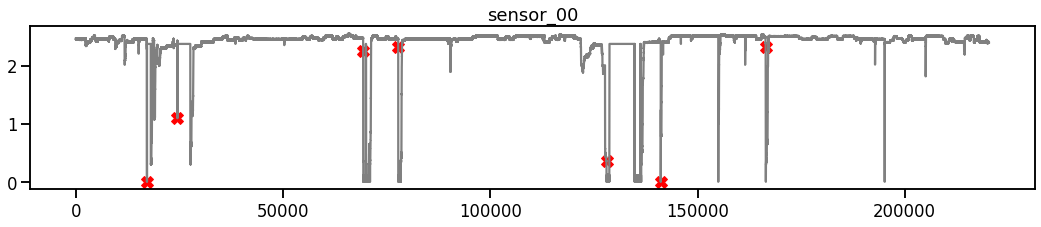

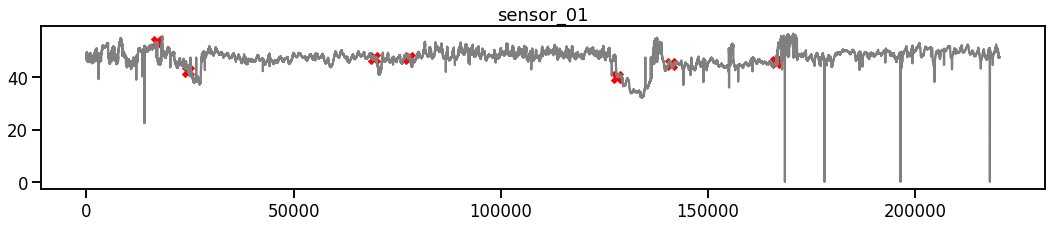

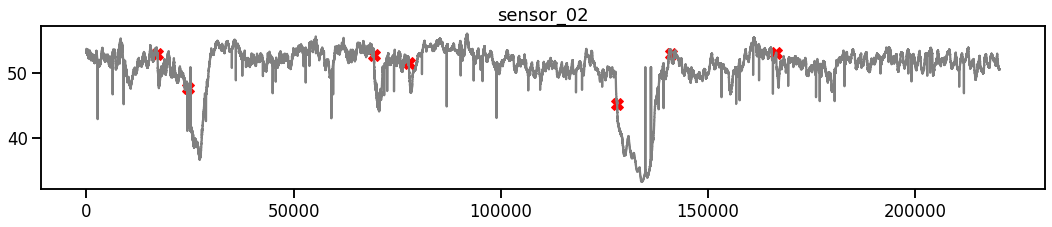

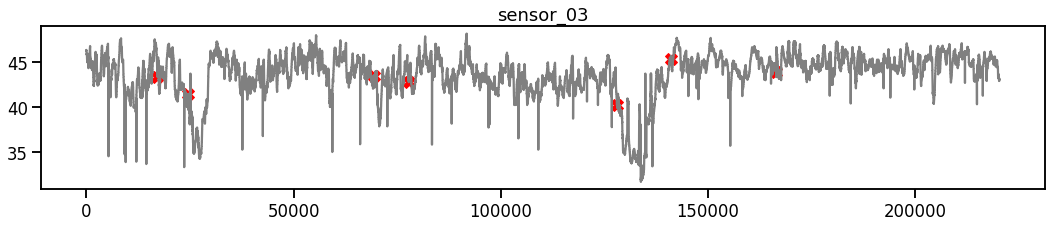

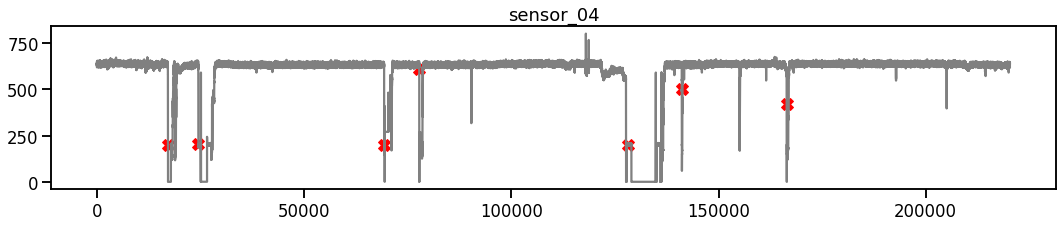

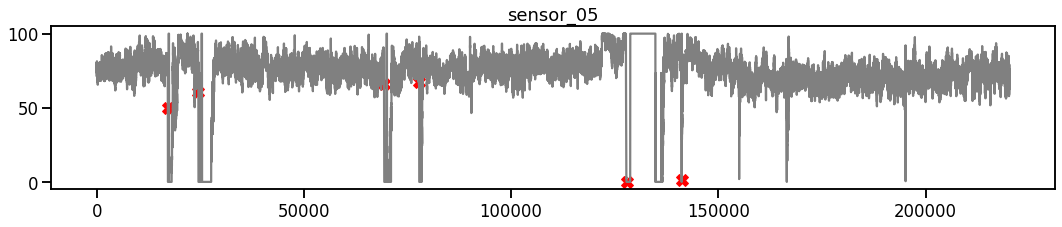

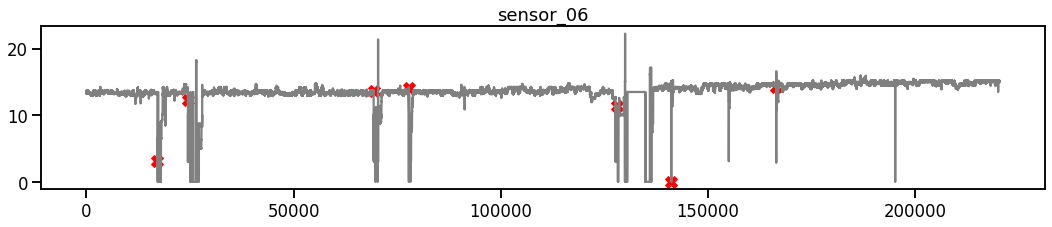

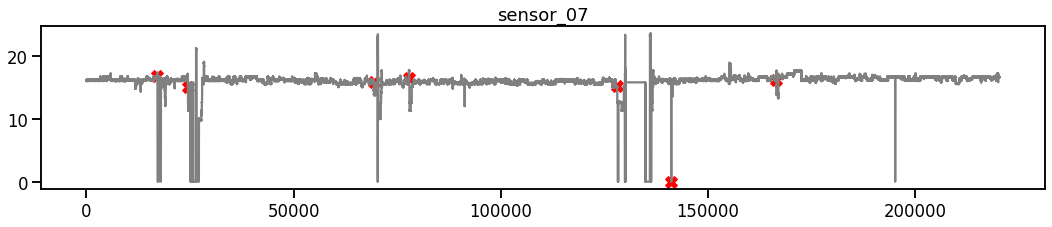

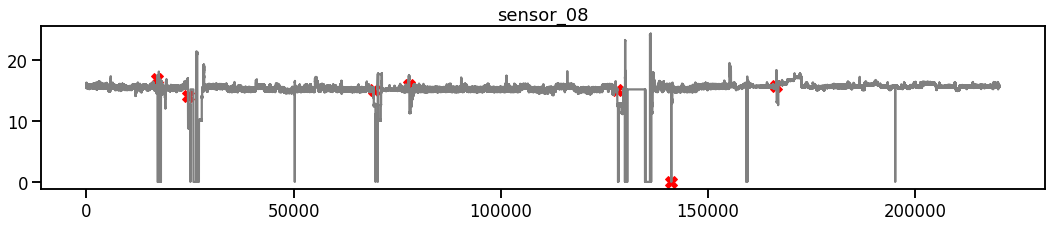

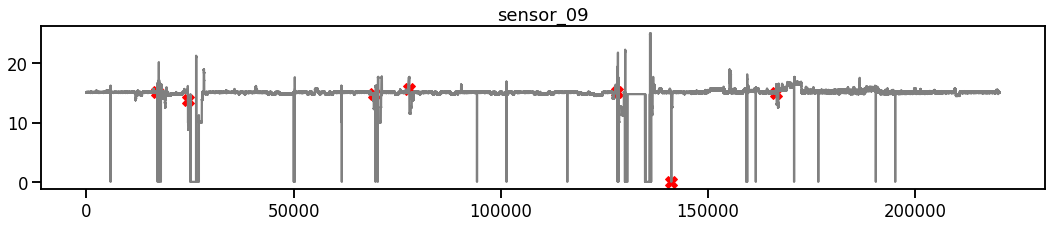

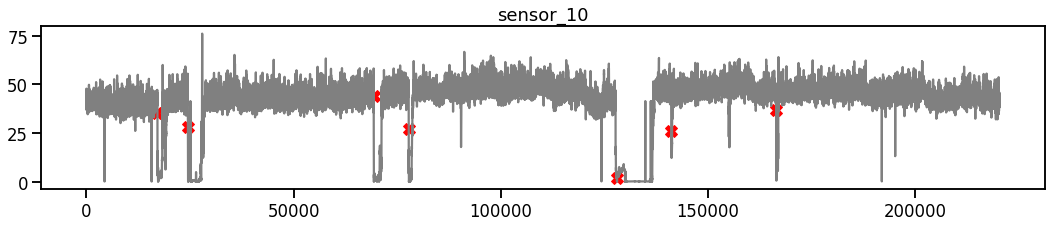

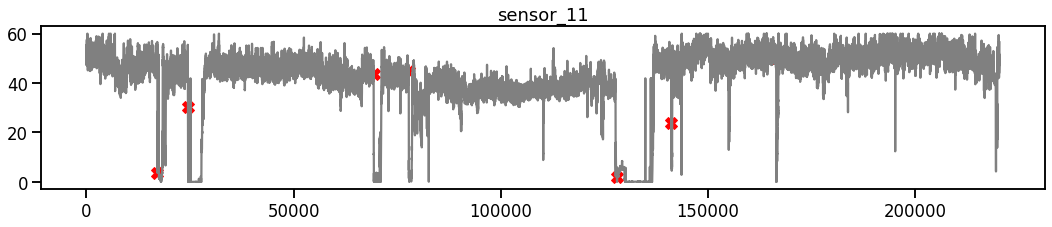

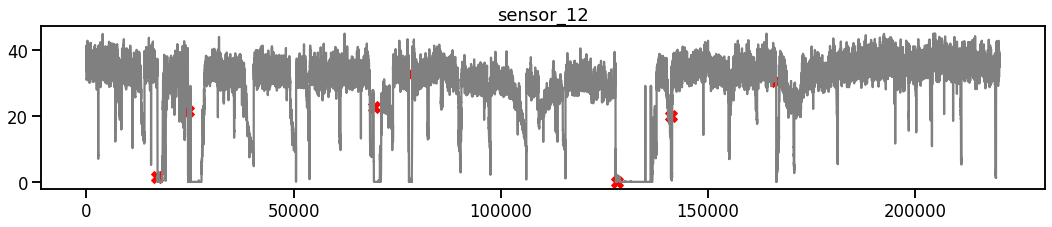

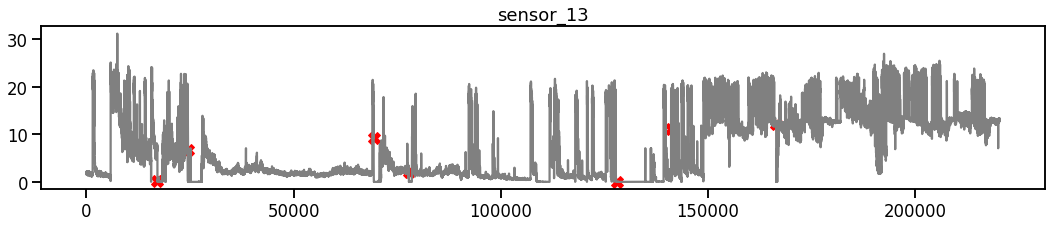

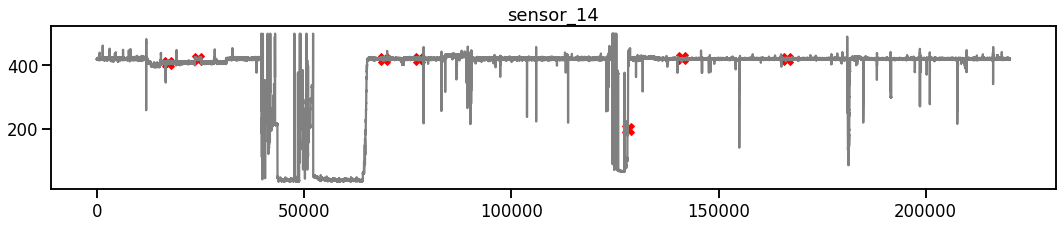

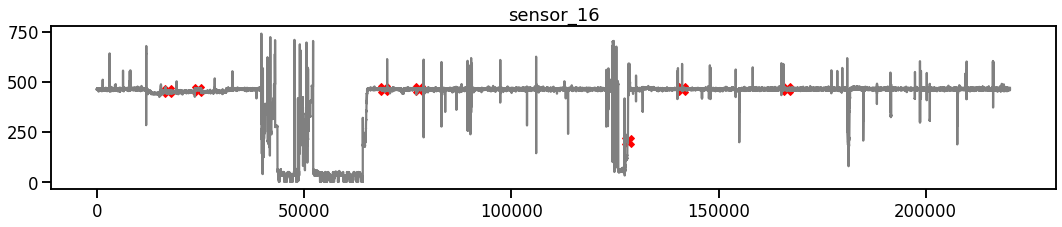

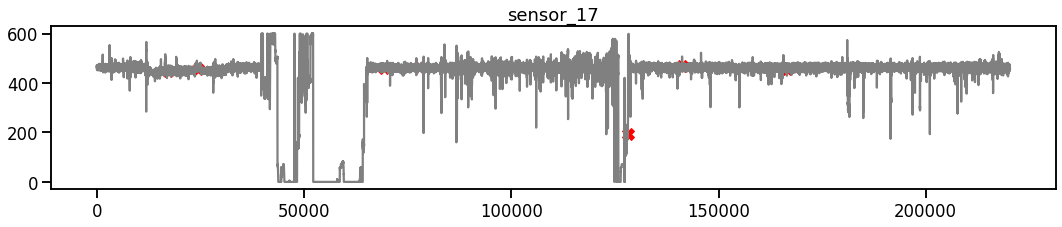

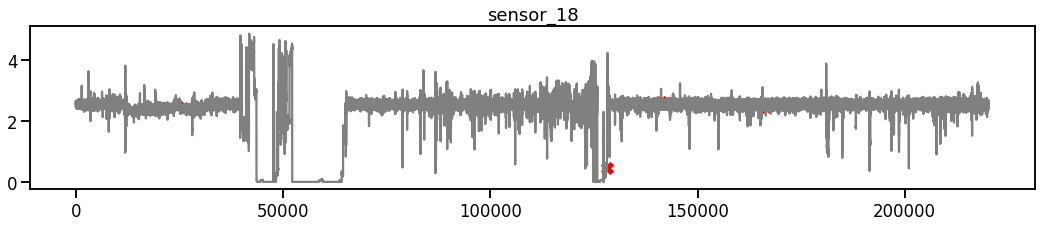

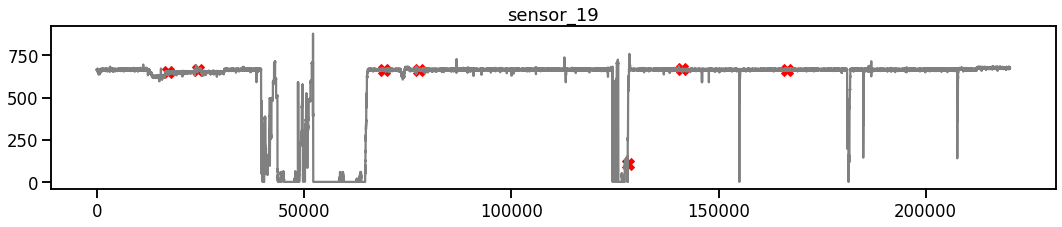

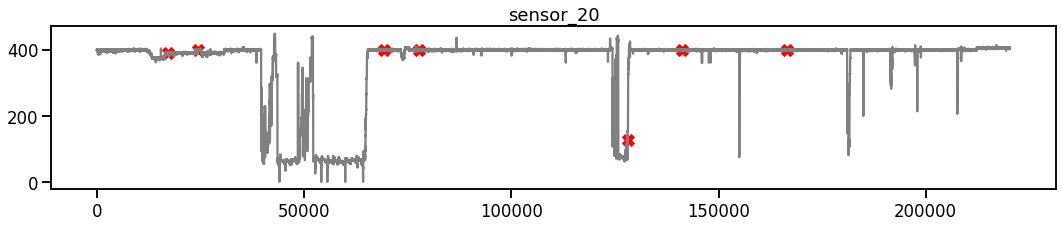

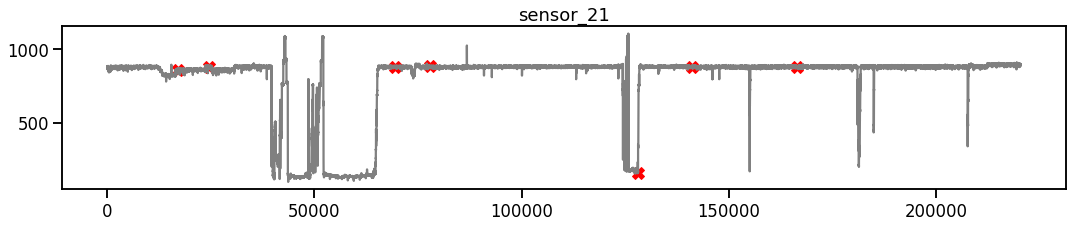

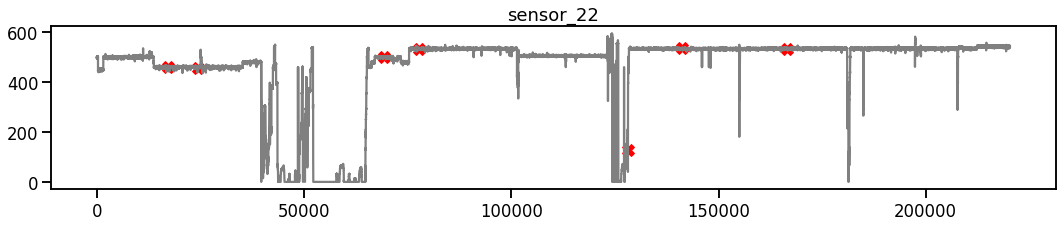

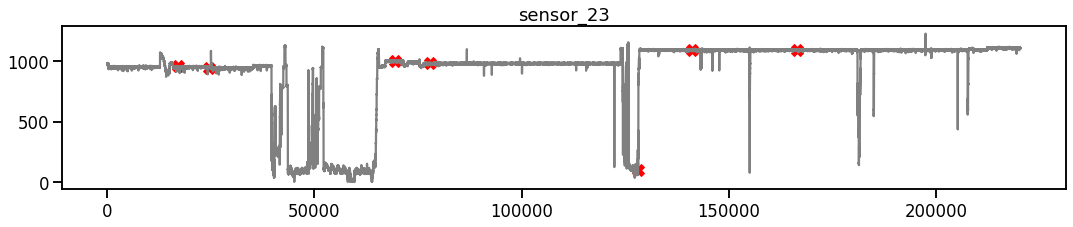

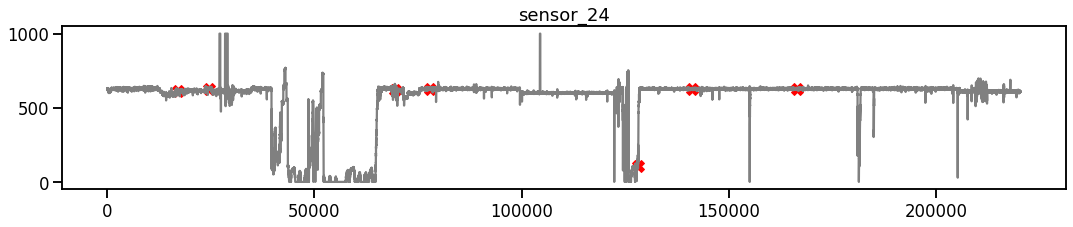

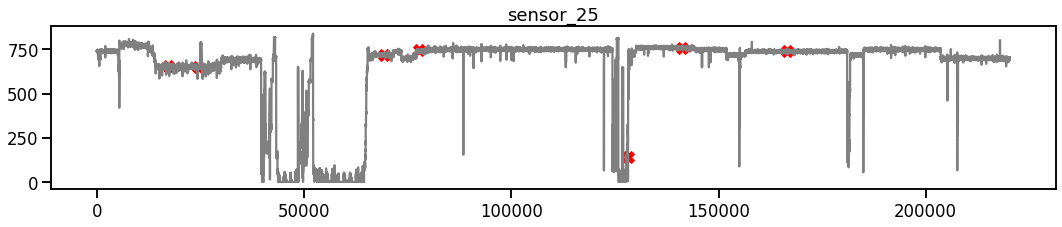

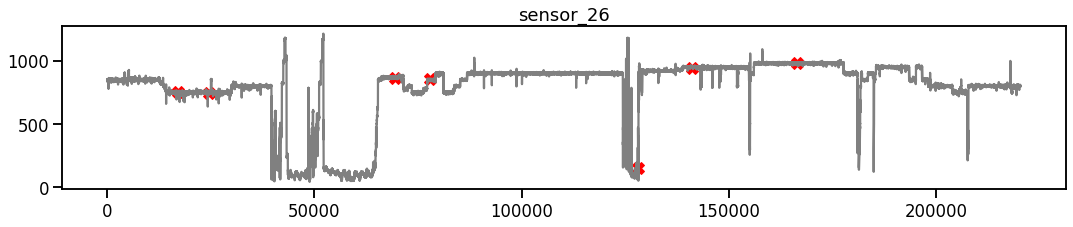

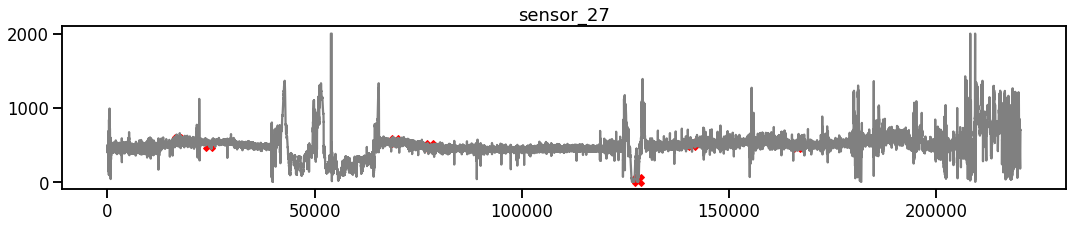

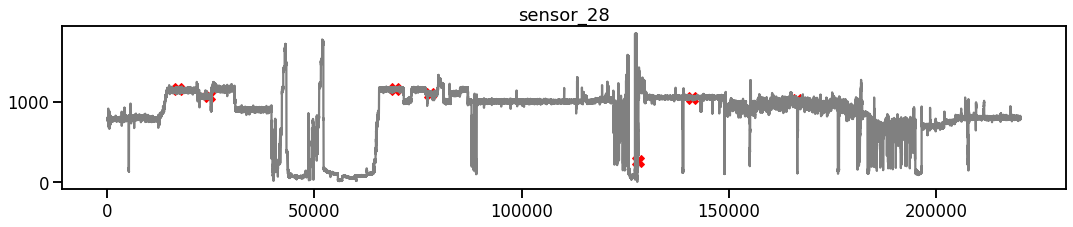

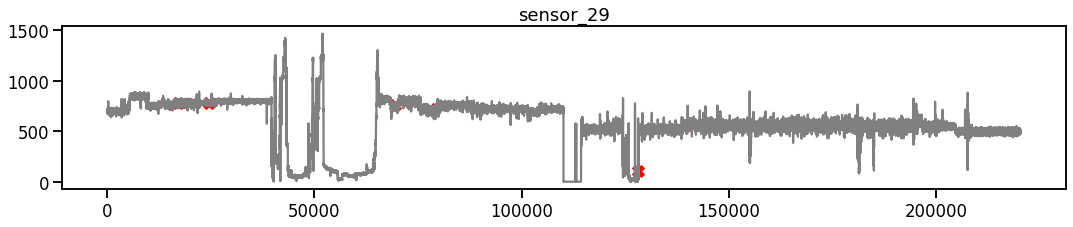

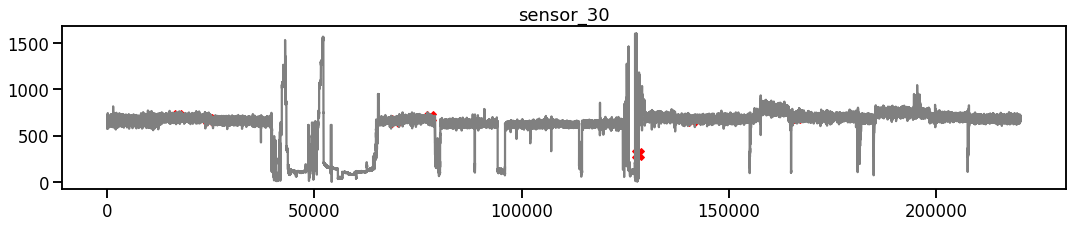

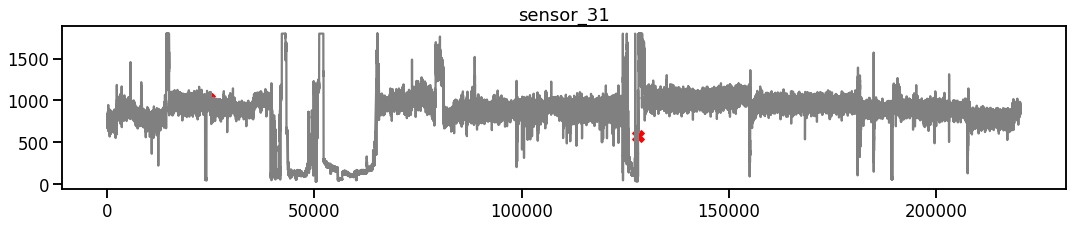

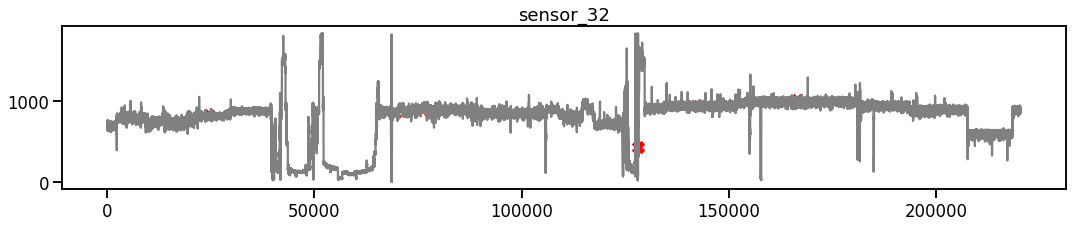

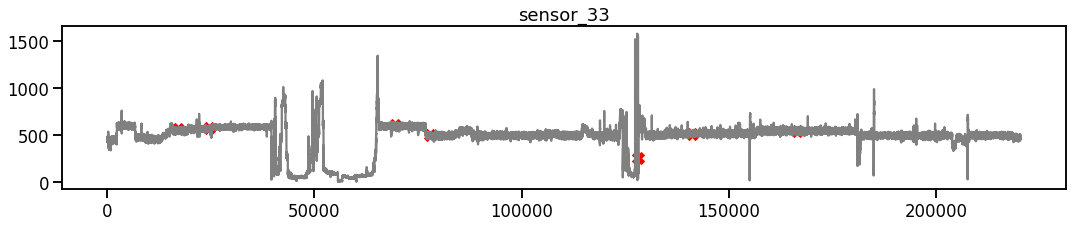

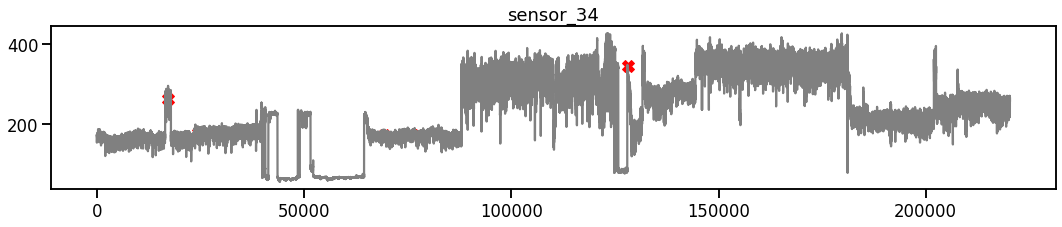

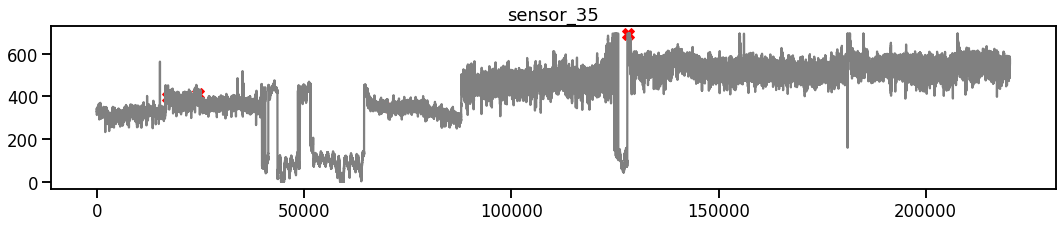

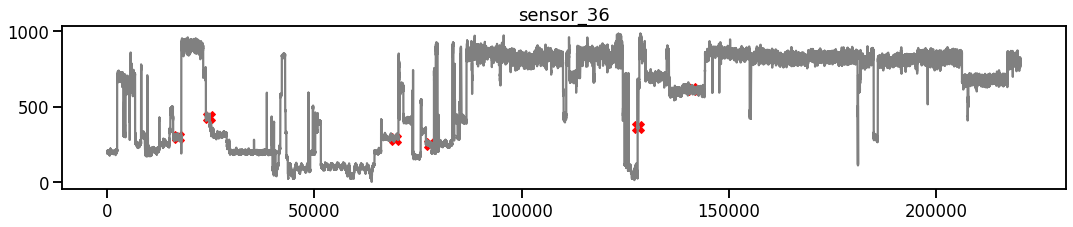

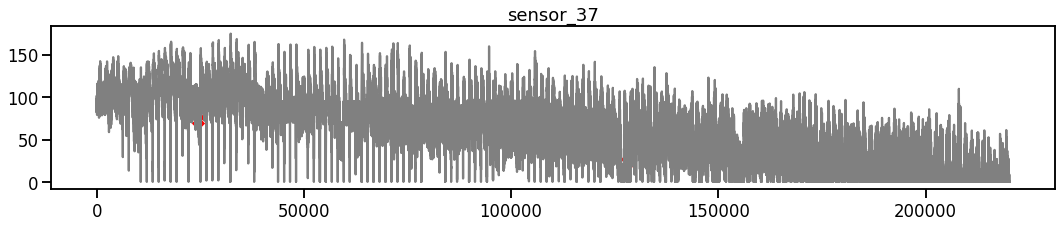

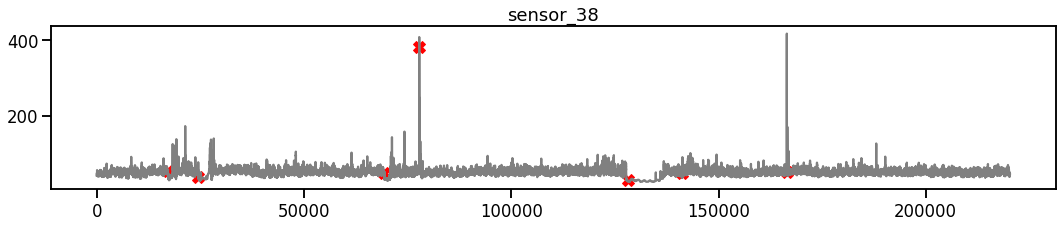

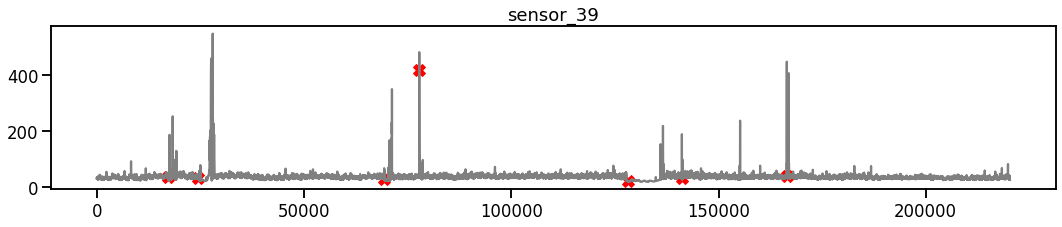

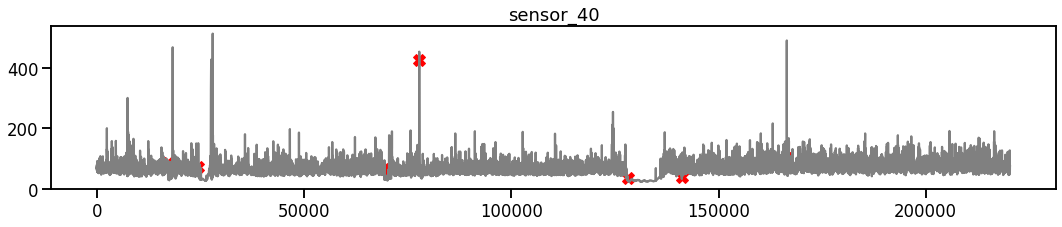

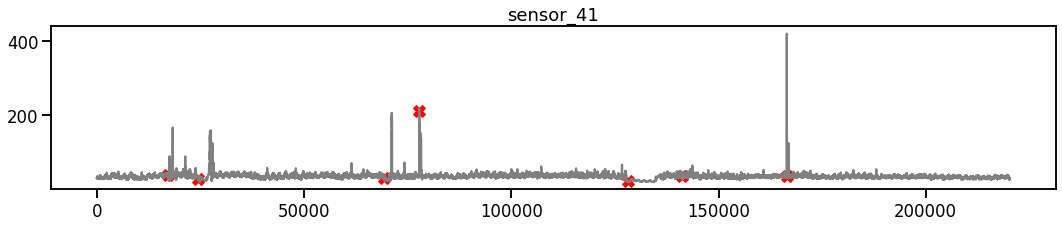

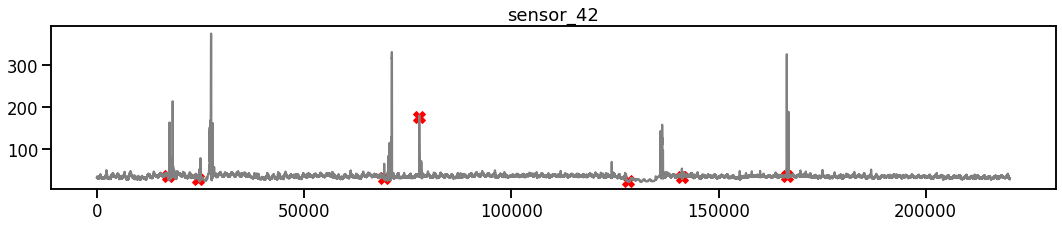

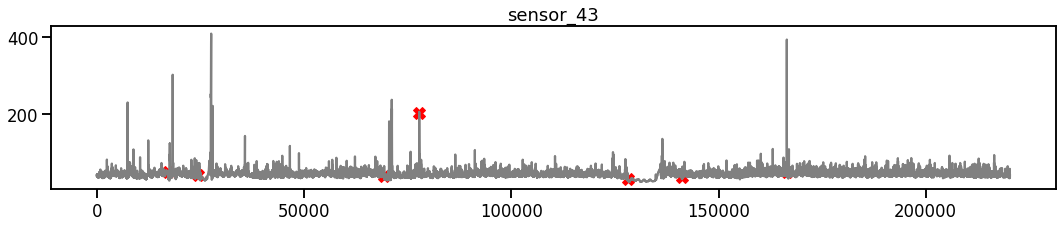

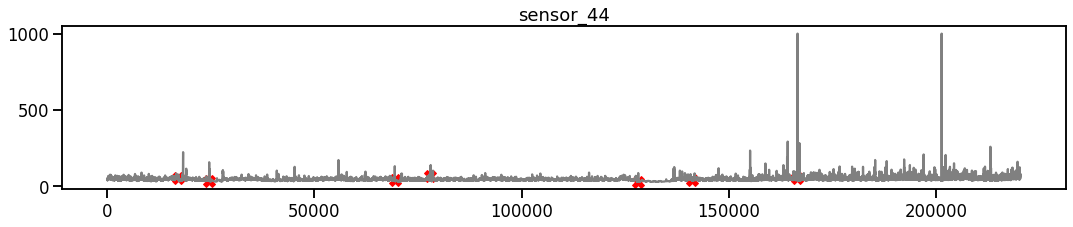

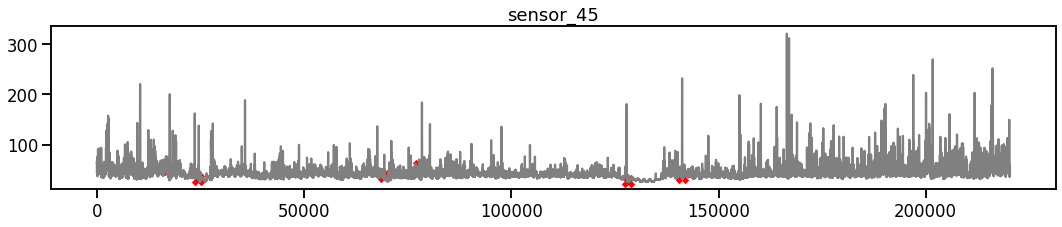

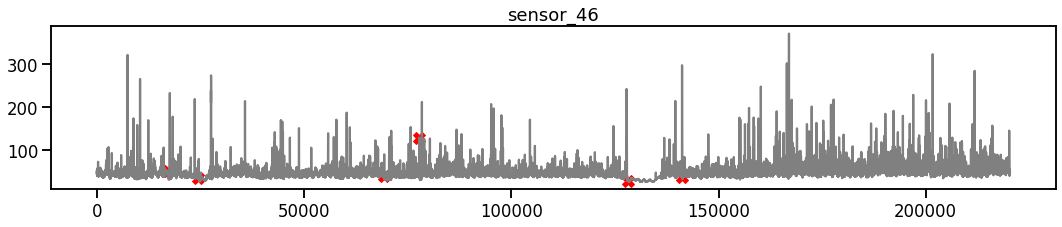

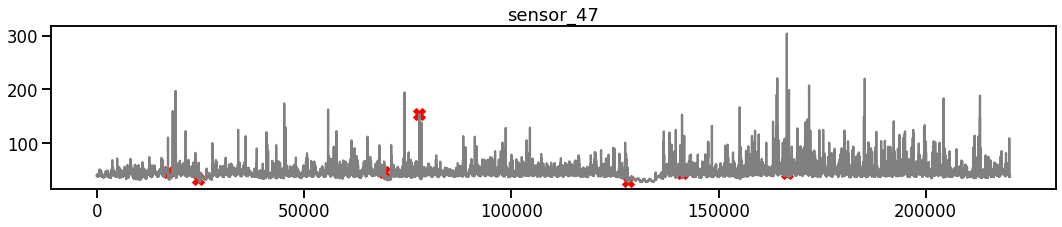

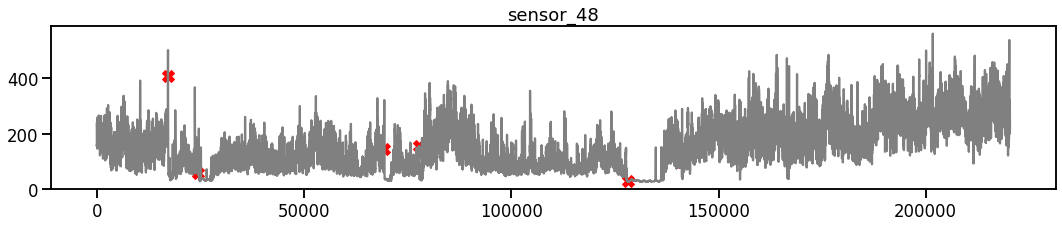

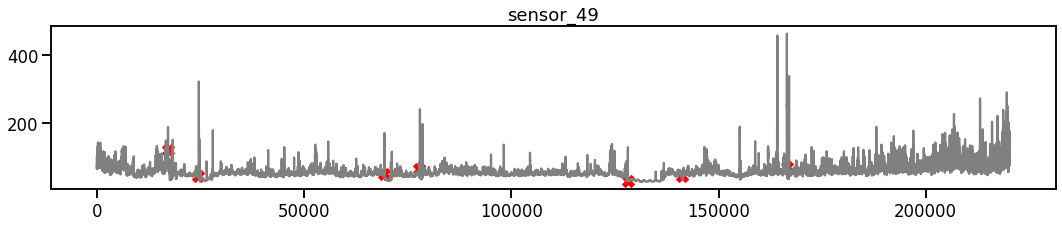

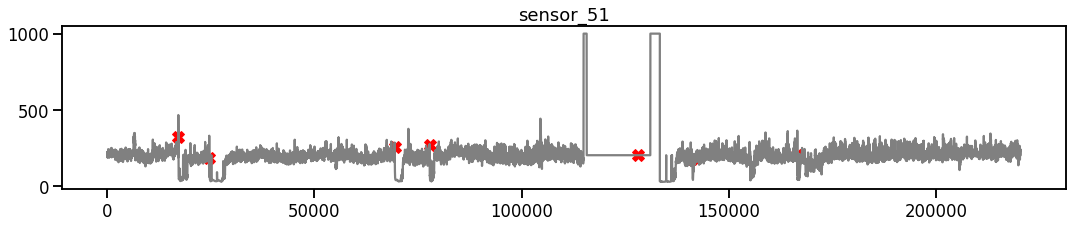

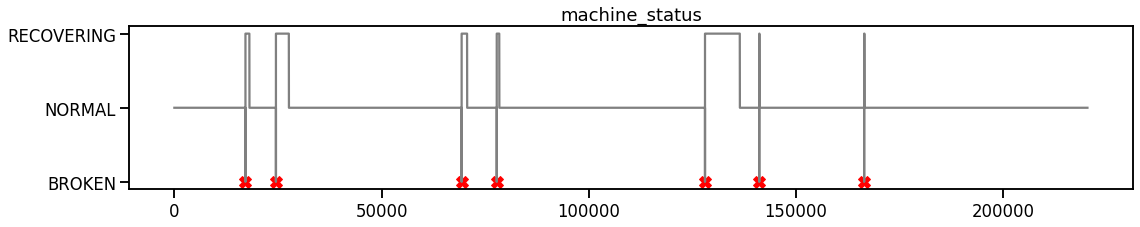

In [11]:
dfBroken = df[df['machine_status']=='BROKEN']
dfSensors = df.drop(['machine_status'], axis=1)
dfSensors = df.drop(['timestamp'], axis=1)
sensorNames=dfSensors.columns
for sensor in sensorNames:
    sns.set_context('talk')
    _ = plt.figure(figsize=(18,3))
    _ = plt.plot(dfBroken[sensor], linestyle='none', marker='X', color='red', markersize=12)
    _ = plt.plot(df[sensor], color='grey')
    _ = plt.title(sensor)
    plt.show()

In [12]:
import datetime

format_str = '%Y-%m-%d %H:%M:%S'  # The format

df['timestamp'] = pd.DataFrame([datetime.datetime.strptime(date, format_str) for date in df['timestamp']])
#y = df.groupby(df.timestamp.dt.year).count()['Date'].values
#x = df.groupby(df.timestamp.dt.year).count()['Date'].index

In [13]:
!pip install pyjanitor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 147 kB 4.3 MB/s 


In [14]:
import janitor

def calculate_rul(df):
    
    df_broken = df[df['machine_status'] == 'BROKEN']
    L=[]
    d = df['timestamp'].iloc[0]
    for date_broken in df_broken['timestamp']:
        
        df_filtered = df.filter_date('timestamp',d, date_broken)
        df_filtered['rul'] = date_broken - df_filtered['timestamp']
        
        L.append(df_filtered)
        d = date_broken
    
    #L.append(df.filter_date('timestamp',df_broken['timestamp'].iloc[-1], df['timestamp'].iloc[-1]))
    result = pd.concat(L)
    

    return result.loc[~result.index.duplicated(keep='first')] #remove duplicates indices

df_rul = calculate_rul(df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [15]:
df_rul['rul']

delta_t = np.timedelta64(4, 'D')
delta_t_2 = np.timedelta64(2, 'D')

In [16]:
# Label1 indicates a failure will occur within the next 30 cycles.
# 1 indicates failure, 0 indicates healthy 
df_rul['label1'] = np.where(df_rul['rul'] <= delta_t, 1, 0 )

Scale the data

In [17]:
from sklearn.preprocessing import MinMaxScaler

cols_normalize = df_rul.columns.difference(['id','timestamp','rul','label1','label2','machine_status'])

scaler = MinMaxScaler()

df_rul[cols_normalize] = scaler.fit_transform(df_rul[cols_normalize])

In [18]:
df_rul["rul"] = df_rul["rul"].apply(lambda x: x.total_seconds()/3600) #converting to hours

In [19]:
#separate in train and test dataset
df_rul[df_rul['machine_status'] =="BROKEN"]

df_rul['time_norm']= df_rul['timestamp'].values.tolist()
df_rul["time_norm"] = (df_rul["time_norm"]-df_rul["time_norm"].min())/(df_rul["time_norm"].max()-df_rul["time_norm"].min())

train_df = df_rul.iloc[:77790,:].drop(['machine_status',"timestamp"],axis=1)
train_df["time_norm"] = (train_df["time_norm"]-train_df["time_norm"].min())/(train_df["time_norm"].max()-train_df["time_norm"].min())


test_df = df_rul.iloc[77791:,:].drop(['machine_status',"timestamp"],axis=1)
test_df["time_norm"] = (test_df["time_norm"]-test_df["time_norm"].min())/(test_df["time_norm"].max()-test_df["time_norm"].min())

train_df['rul'] = train_df['rul'].values.tolist()

In [20]:
test_df['rul'].describe()

count    88650.000000
mean       313.676782
std        231.096187
min          0.000000
25%        123.116667
50%        260.275000
75%        468.112500
max        837.483333
Name: rul, dtype: float64

###Generate data

In [21]:
features_col_name=[column for column in df.columns if not column.find('sensor')]
target_col_name='label1'

features_col_name

['sensor_00',
 'sensor_01',
 'sensor_02',
 'sensor_03',
 'sensor_04',
 'sensor_05',
 'sensor_06',
 'sensor_07',
 'sensor_08',
 'sensor_09',
 'sensor_10',
 'sensor_11',
 'sensor_12',
 'sensor_13',
 'sensor_14',
 'sensor_16',
 'sensor_17',
 'sensor_18',
 'sensor_19',
 'sensor_20',
 'sensor_21',
 'sensor_22',
 'sensor_23',
 'sensor_24',
 'sensor_25',
 'sensor_26',
 'sensor_27',
 'sensor_28',
 'sensor_29',
 'sensor_30',
 'sensor_31',
 'sensor_32',
 'sensor_33',
 'sensor_34',
 'sensor_35',
 'sensor_36',
 'sensor_37',
 'sensor_38',
 'sensor_39',
 'sensor_40',
 'sensor_41',
 'sensor_42',
 'sensor_43',
 'sensor_44',
 'sensor_45',
 'sensor_46',
 'sensor_47',
 'sensor_48',
 'sensor_49',
 'sensor_51']

In [22]:
# window size
seq_length=100
seq_cols=features_col_name

In [23]:
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

# function to generate labels
def gen_labels(id_df, seq_length, label):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]] 
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[seq_length:num_elements, :]

In [24]:
# generate X_train for TCN 3D dimension array
seq_gen = [list(gen_sequence(train_df, seq_length, seq_cols))]

seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

(77690, 100, 50)


In [25]:
label_gen = [gen_labels(train_df, seq_length, ['label1'])]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(77690, 1)

##TCN model


###Model design 1

In [27]:
lookback_window = seq_array.shape[1]

In [28]:
i = Input(shape=(lookback_window, seq_array.shape[2]))
m = TCN()(i)
m = Dense(1, activation='linear')(m)

model = Model(inputs=[i], outputs=[m])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 50)]         0         
                                                                 
 tcn (TCN)                   (None, 64)                148800    
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 148,865
Trainable params: 148,865
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.compile('adam','mae')

In [32]:
import time
import keras

t0 = time.time()

model.fit(seq_array, # Training features
          label_array, # Training labels
          epochs=10,   # We'll stop after 10 epochs
          batch_size=200, # 
          validation_split=0.10, # Use 10% of data to evaluate the loss. (val_loss)
          verbose=1, #
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', # Monitor the validation loss
                                                     min_delta=0,    # until it doesn't change (or gets worse)
                                                     patience=5,  # patience > 1 so it continutes if it is not consistently improving
                                                     verbose=0, 
                                                     mode='auto')])

print("Training took "+str(time.time() - t0)+" seconds")

Epoch 1/10
350/350 [==============================] - 11s 31ms/step - loss: 0.0277 - val_loss: 0.4229
Epoch 2/10
350/350 [==============================] - 11s 30ms/step - loss: 0.0323 - val_loss: 0.4318
Epoch 3/10
350/350 [==============================] - 11s 30ms/step - loss: 0.0251 - val_loss: 0.3770
Epoch 4/10
350/350 [==============================] - 11s 30ms/step - loss: 0.0184 - val_loss: 0.4769
Epoch 5/10
350/350 [==============================] - 11s 30ms/step - loss: 0.0184 - val_loss: 0.4138
Epoch 6/10
350/350 [==============================] - 11s 31ms/step - loss: 0.0169 - val_loss: 0.4504
Epoch 7/10
350/350 [==============================] - 11s 30ms/step - loss: 0.0350 - val_loss: 0.3706
Epoch 8/10
350/350 [==============================] - 11s 31ms/step - loss: 0.0164 - val_loss: 0.3794
Epoch 9/10
350/350 [==============================] - 11s 31ms/step - loss: 0.0128 - val_loss: 0.3950
Epoch 10/10
350/350 [==============================] - 11s 31ms/step - loss: 0.015

In [34]:
from sklearn.metrics import fbeta_score
from sklearn.metrics import confusion_matrix, recall_score, precision_score
# make predictions and compute confusion matrix
y_pred = (model.predict(seq_array) > 0.5).astype("int32")
#y_pred = model.predict_classes(seq_array,verbose=1, batch_size=200)
y_true = label_array
print('Training Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
cm

Training Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[53735,   912],
       [ 1978, 21065]])

In [35]:
# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = 2 * (precision * recall) / (precision + recall)
print( 'Training Precision: ', precision, '\n', 'Training Recall: ', recall, '\n', 'Training F1 Score:', f1)
print(fbeta_score(y_true, y_pred,beta=0.5))

Training Precision:  0.9585020703462711 
 Training Recall:  0.9141604825760534 
 Training F1 Score: 0.935806308307419
0.9492929311137348
